In [1]:
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import os
sns.set_theme()

In [2]:
def subj_file(subj_str: str, trial_type: str, data_type: str):
    folder = f"bloodflow_data/{subj_str}"
    filename = None
    files = None
    
    if trial_type in ['baseline', 'base', 'basline']:
        files = [file_name for file_name in os.listdir(folder) if 'baseline' in file_name or 'basline' in file_name or 'base' in file_name]

    elif trial_type in ['post-oc', 'post-occ', 'post-occlusion', 'post']:
        files = [file_name for file_name in os.listdir(folder) if 'post' in file_name]

    else:
        raise ValueError(f"{trial_type} is not an acceptable parameter for trial_type")
    
    if data_type in ['diameter', 'diam']:
        files = [file_name for file_name in files if 'diam' in file_name]
        filename = files[0][:-4]
    elif data_type in ['time', 'time_series', 'time series', 'cyclic'] :
        files = [file_name for file_name in files if 'flow' in file_name or 'doppler' in file_name]
        filename = files[0][:str.index(files[0], '_')]
        
    else:
        raise ValueError(f"{data_type} is not an acceptable parameter for data_type")
    
    return f"{folder}/{filename}"

In [3]:
def get_matlab_data(filename: str):
    matlab_data = sp.io.loadmat(f"{filename}.fig")[
        "hgS_070000"]["children"][0][0][0]["children"][0][0][0]["properties"]["YData"][0][0][0]
    
    matlab_data[matlab_data == -1] = np.NaN
    raw_data = np.load(f"{filename}.npy")
    
    return matlab_data * raw_data['px_to_cm']

In [4]:
def get_raw_data(filename: str):
    raw_data = np.load(f"{filename}.npy")
    return raw_data["diameters"] * raw_data['px_to_cm']

In [5]:
def spline_interpolate_nan(array):
    nan_indices = np.isnan(array)
    valid_indices = np.arange(len(array))[~nan_indices]
    valid_values = array[~nan_indices]
    
    spline = sp.interpolate.UnivariateSpline(valid_indices, valid_values, s=0)

    # Interpolate NaN values using the fitted spline
    array[nan_indices] = spline(np.flatnonzero(nan_indices))
    return array

In [6]:
def filter_diameter(diameter_series: np.ndarray, cutoff_frame=False, apply_median_filter=False):

    # print(f"Percent NaN before filtering: {diameter_series.isna().sum() / len(diameter_series) * 100}%")
    
    diameter_array = diameter_series.copy()
    
    # Interpolate NaN values
    interpolated_diameter = spline_interpolate_nan(diameter_array.copy())
    
    # Low-pass and high-pass filter parameters
    low_pass_cutoff_frequency = 0.05
    filter_order = 2
    
    # Apply high-pass filter
    highpass_filter = sp.signal.butter(filter_order, low_pass_cutoff_frequency, 'highpass', output='sos')
    highpass_filtered = sp.signal.sosfilt(highpass_filter, interpolated_diameter)
    
    # Plot high-pass filtered data before thresholding
    
    # Calculate deviation and identify outliers
    deviation_threshold = np.std(highpass_filtered) * 0.9
    outlier_mask = (highpass_filtered > deviation_threshold) | (highpass_filtered < -deviation_threshold)
    
    # Exclude the first and last 30 samples to prevent ringing from high pass filtering
    outlier_mask[:30] = False
    outlier_mask[-30:] = False
    
    # Mark indices to be removed, including 2 indices before and after
    removal_mask = np.zeros_like(highpass_filtered, dtype=bool)
    for index in range(len(outlier_mask)):
        if outlier_mask[index]:
            start = max(0, index - 1)
            end = min(len(outlier_mask), index + 2)
            removal_mask[start:end] = True
    
    # Set outliers to NaN
    diameter_array[removal_mask] = np.NaN
    highpass_filtered[removal_mask] = np.NaN
    
    
    # Calculate median and threshold for further filtering
    median_diameter = np.nanmedian(diameter_array)
    filtering_threshold = np.nanstd(diameter_array) * 2
    extreme_outlier_mask = (diameter_array > median_diameter + filtering_threshold) | (diameter_array < median_diameter - filtering_threshold)
    
    
    # Set extreme outliers to NaN
    diameter_array[extreme_outlier_mask] = np.NaN
    
    # Convert to DataFrame
    diameter_dataframe = pd.DataFrame({"diameter": diameter_array})
    
    # print(f"Percent NaN after filtering: {diameter_dataframe.isna().sum() / len(diameter_dataframe) * 100}%")
    
    
    # Apply cutoff frame if specified
    if cutoff_frame:
        diameter_dataframe = diameter_dataframe.iloc[:cutoff_frame]
    
    # Apply median filter if specified
    if apply_median_filter:
        diameter_dataframe = diameter_dataframe.rolling(window=len(diameter_dataframe) // 50, min_periods=1).median()
    
    return diameter_dataframe

Get Valid Files

In [7]:
files = []
subj_nums = list(range(5,25))
subj_name = lambda num: f"ASCI{num:03}"

exclude = []
for subj_num in subj_nums:
    if subj_num not in exclude:
        files.append(subj_file(subj_name(subj_num), 'baseline', 'diam'))
        files.append(subj_file(subj_name(subj_num), 'post', 'diam'))
        
subj_nums = list(range(1,15))
subj_name = lambda num: f"ASCI1{num:02}"

exclude = []
for subj_num in subj_nums:
    if subj_num not in exclude:
        files.append(subj_file(subj_name(subj_num), 'baseline', 'diam'))
        files.append(subj_file(subj_name(subj_num), 'post', 'diam'))
        
files = np.array(files)
files = np.unique(files)

Run-length of NaNs

In [8]:
def run_length_nans(arr):
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input should be a numpy array")
    
    nans = np.isnan(arr)
    
    if not np.any(nans):
        return []
    
    # Calculate differences to identify the boundaries of NaN runs
    diff = np.diff(nans.astype(int))
    starts = np.where(diff == 1)[0] + 1
    ends = np.where(diff == -1)[0] + 1
    
    # Handle case where NaN run starts at the beginning
    if nans[0]:
        starts = np.insert(starts, 0, 0)
    
    # Handle case where NaN run ends at the end
    if nans[-1]:
        ends = np.append(ends, len(nans))
    
    # Calculate lengths of NaN runs
    run_lengths = ends - starts
    
    run_lengths = run_lengths / len(arr)
    return run_lengths.tolist()

In [9]:
band = lambda arr, lower_bound, upper_bound: np.where((arr >= lower_bound) & (arr <= upper_bound), arr, np.nan)

In [10]:
def gaps_bwave(filename):
    diameter_data = get_raw_data(filename)
    diameter_data = filter_diameter(diameter_data)
    diameter_data = diameter_data['diameter'].to_numpy()
    diameter_data = band(diameter_data, 0.22, 0.64)
    return run_length_nans(diameter_data)

In [11]:
def gaps_flowave(filename):
    diameter = get_matlab_data(filename)
    diameter = band(diameter, 0.22, 0.64)
    return run_length_nans(diameter)

In [12]:
def diameter_bwave(filename):
    diameter = get_raw_data(filename)
    diameter = filter_diameter(diameter)
    return diameter['diameter'].to_numpy()

In [13]:
def diameter_flowave(filename):
    return get_matlab_data(filename)

In [14]:
flowave = []
bwave = []
for filename in files:
    bwave.append(gaps_bwave(filename))
    flowave.append(gaps_flowave(filename))

# per video frames captured analysis

In [15]:
bwave_fpv = []
flowave_fpv = []
for b_video, f_video in zip(bwave, flowave):
    bwave_fpv.append(np.sum(b_video))
    flowave_fpv.append(np.sum(f_video))

In [16]:
frame_data = pd.DataFrame()
frame_data['accurate frames read'] = 1 - (np.concatenate([bwave_fpv, flowave_fpv]))
frame_data['method'] =  ['bwave'] * len(bwave) + ['flowave'] * len(flowave)
frame_data['trial'] = len(frame_data)//2 * ['baseline', 'post'] 

Text(0.5, 0, '% of Accurate Frames Read')

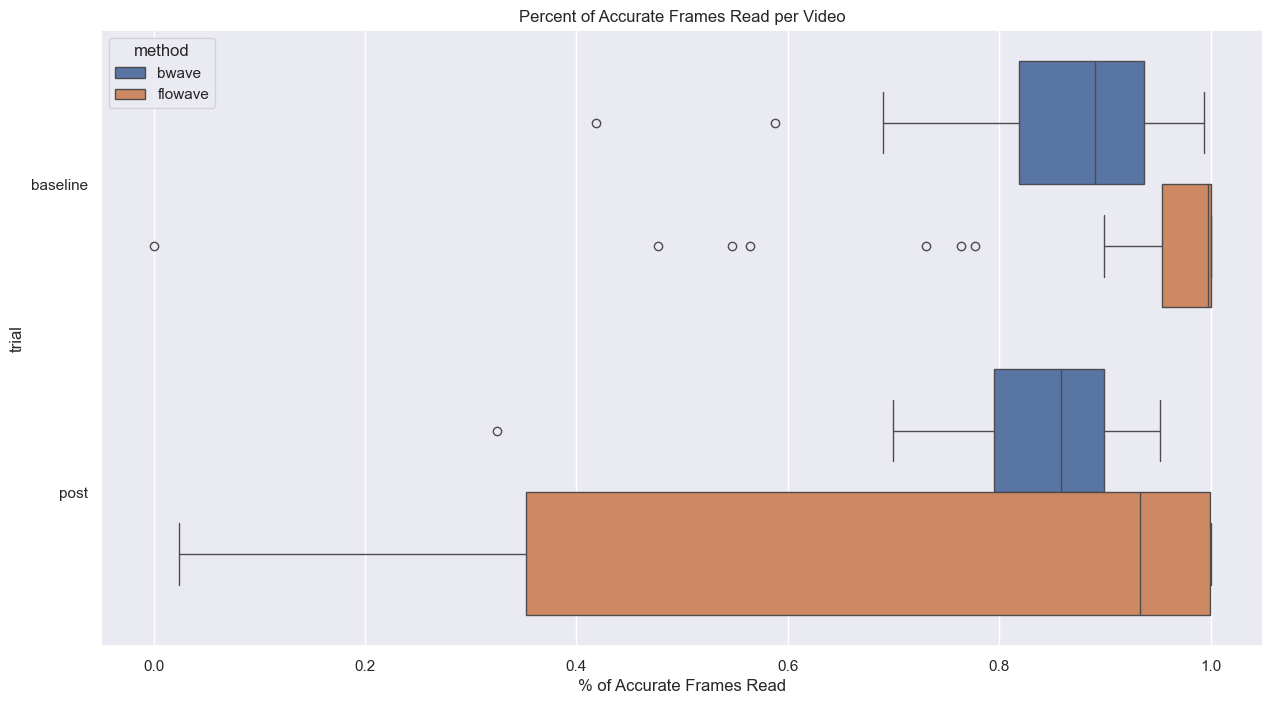

In [17]:
plt.figure(figsize=(15,8))
sns.boxplot(data = frame_data, x = 'accurate frames read', y = 'trial', hue = 'method')
plt.title('Percent of Accurate Frames Read per Video')
plt.xlabel('% of Accurate Frames Read')

<Axes: xlabel='accurate frames read', ylabel='trial'>

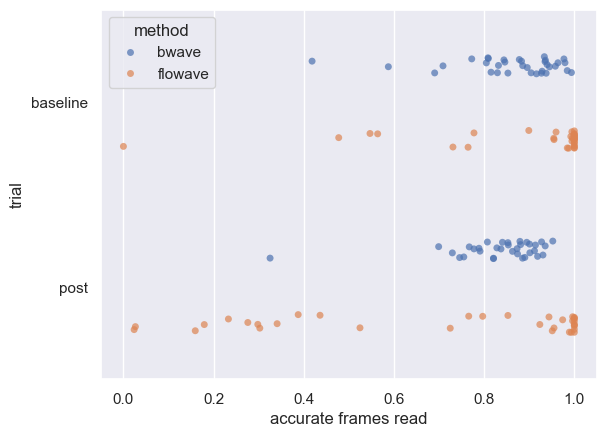

In [18]:
sns.stripplot(data = frame_data, x = 'accurate frames read', y = 'trial', hue = 'method', alpha = 0.7, dodge=True)

<Axes: xlabel='accurate frames read', ylabel='method'>

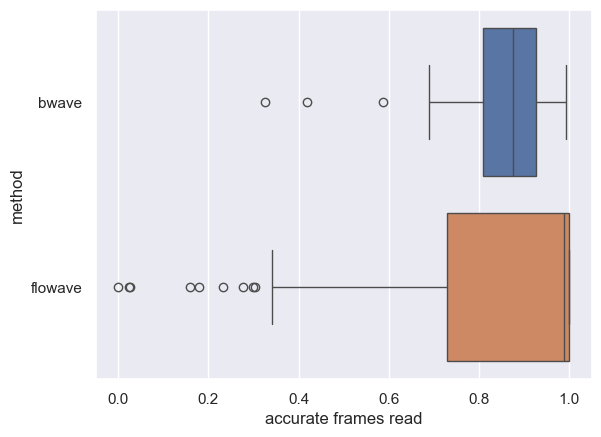

In [19]:
sns.boxplot(data = frame_data, x = 'accurate frames read', y = 'method', hue = 'method')

In [20]:
frame_data[frame_data['method'] == 'bwave'].describe()

,accurate frames read
count,68.000000
mean,0.848373
std,0.115450
min,0.325254
25%,0.809084
50%,0.876004
75%,0.927163
max,0.993639


In [21]:
frame_data[frame_data['method'] == 'flowave'].describe()

,accurate frames read
count,68.000000
mean,0.803345
std,0.303394
min,0.000000
25%,0.729310
50%,0.988202
75%,1.000000
max,1.000000


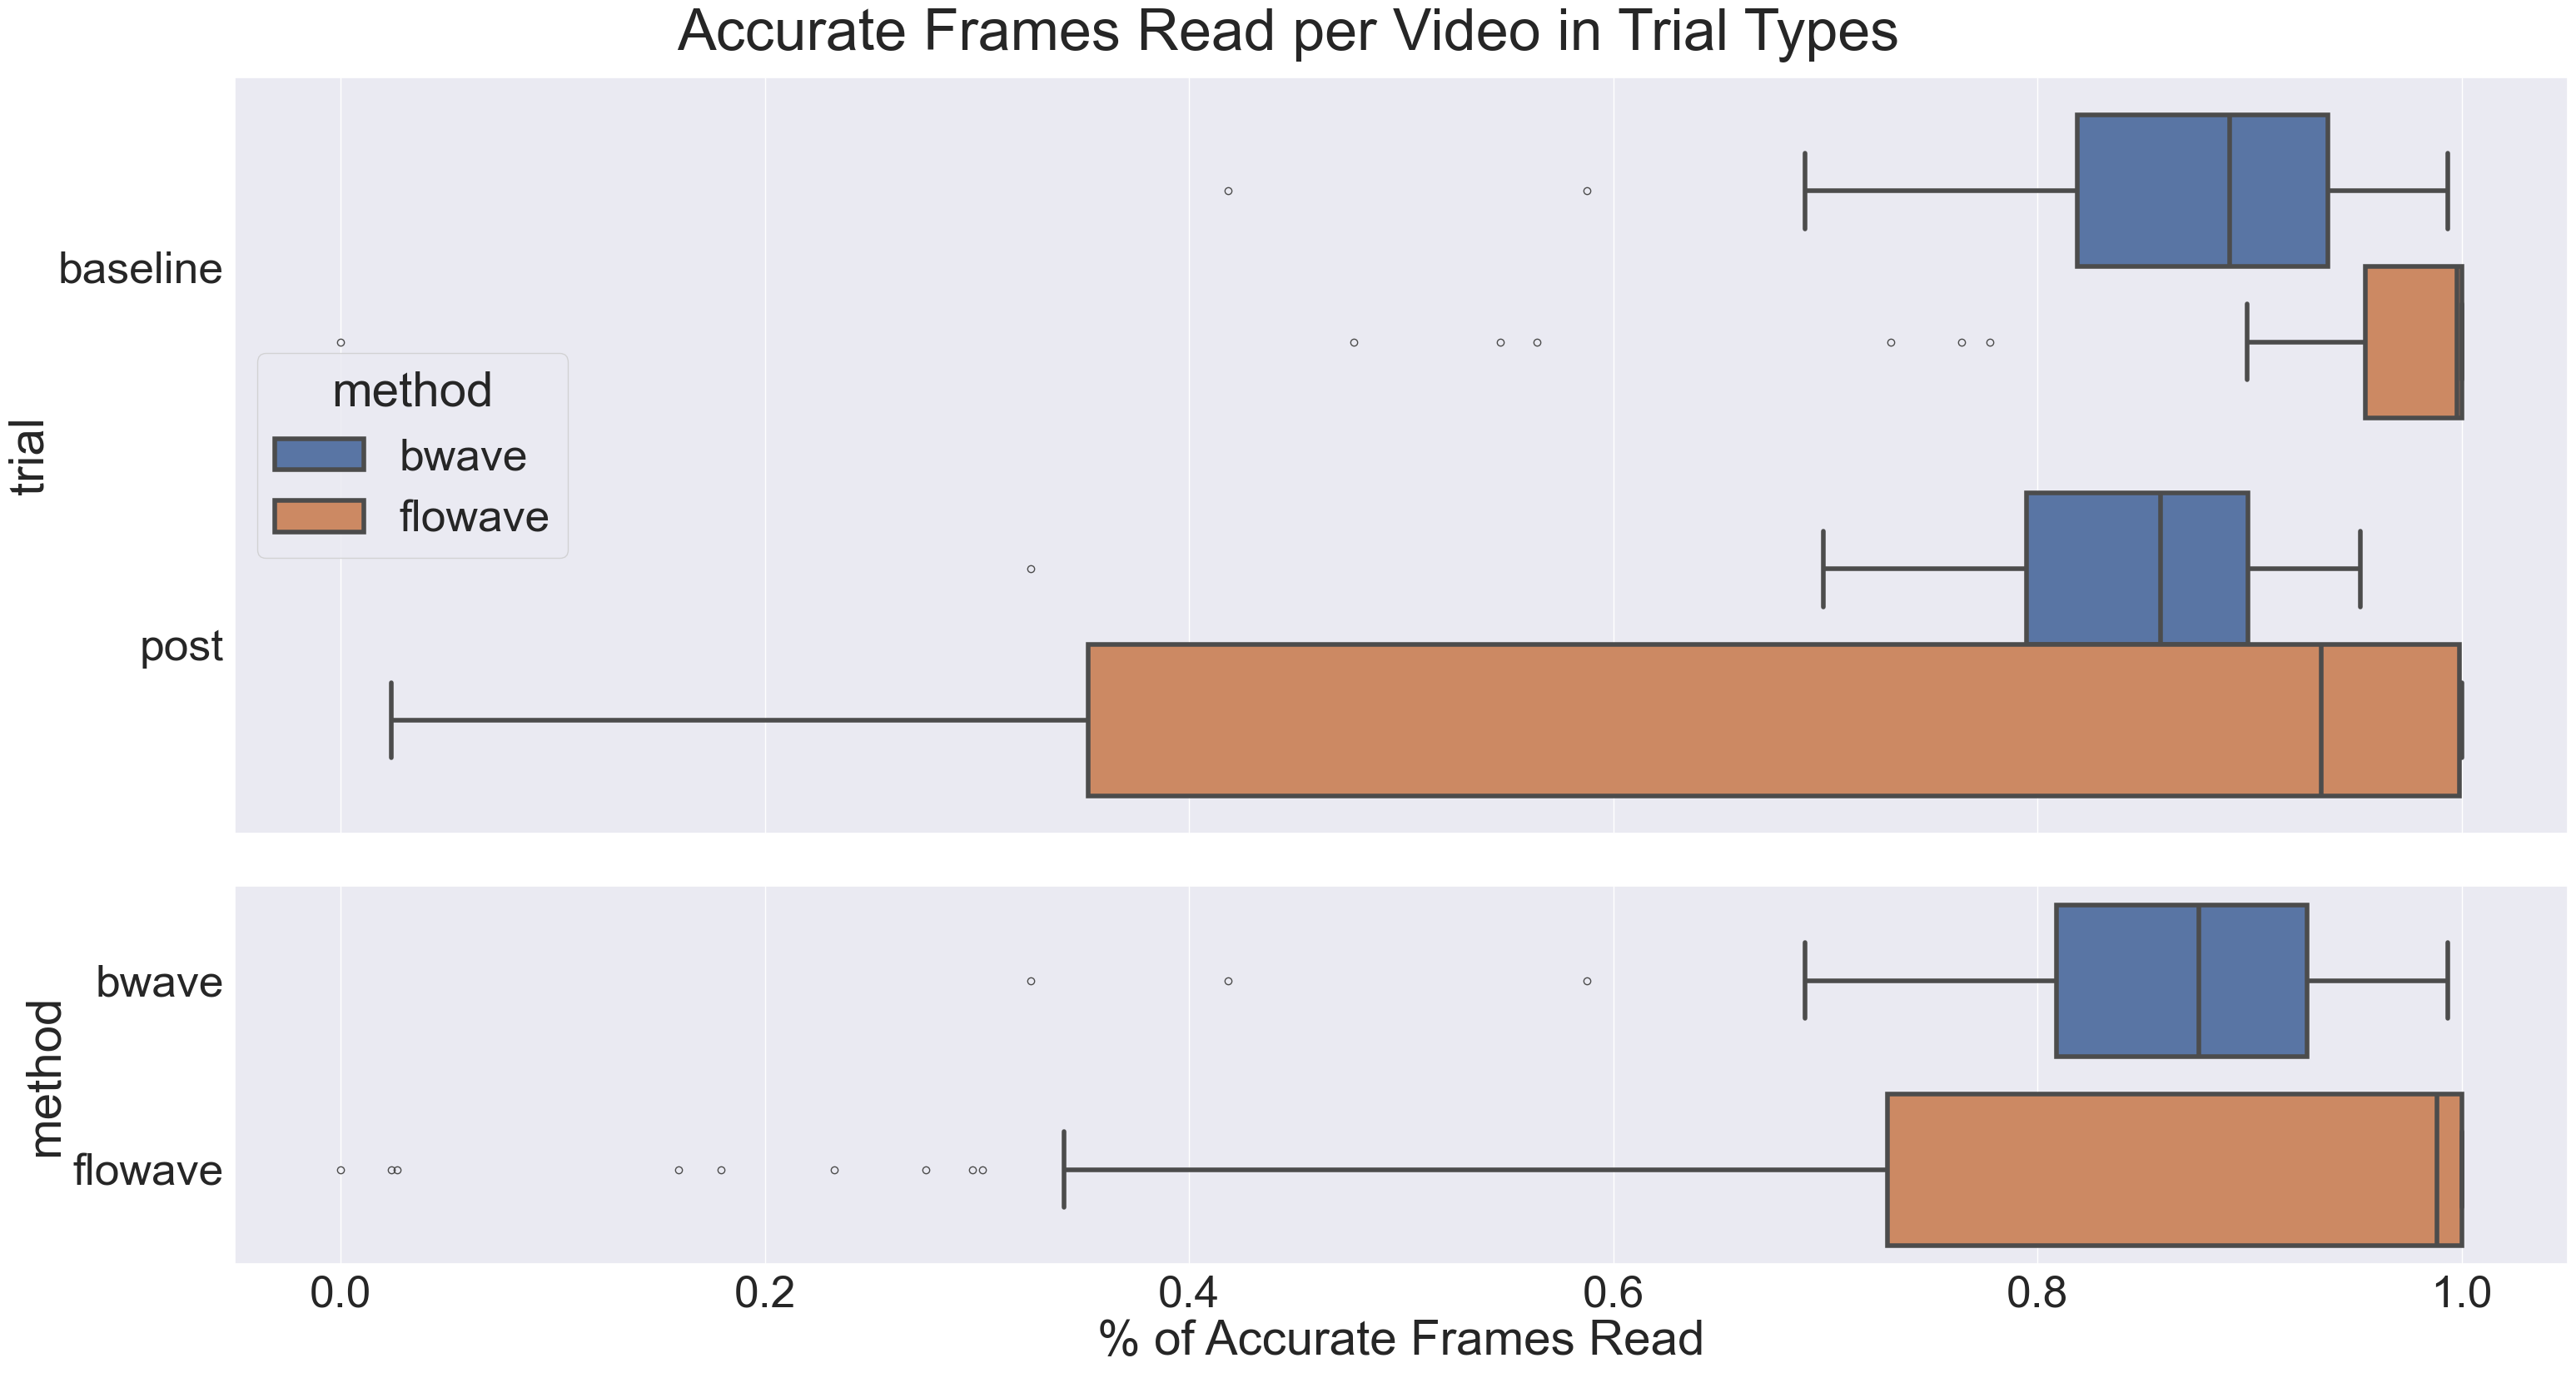

In [22]:
sns.set(font_scale=3.5)
fig, ax = plt.subplots(2,1 , figsize=(32,18), height_ratios= [2,1], sharex = True)
sns.boxplot(data = frame_data, x = 'accurate frames read', y = 'trial', hue = 'method', ax = ax[0], fill = True, linewidth=4)
sns.boxplot(data = frame_data, x = 'accurate frames read', y = 'method',  hue = 'method', ax = ax[1], fill = True, linewidth=4)
plt.suptitle("Accurate Frames Read per Video in Trial Types", y = 0.94)
plt.xlabel('% of Accurate Frames Read')
plt.tight_layout()
plt.show()
sns.set(font_scale=1)


# Gap Sizes

In [23]:
flowave = np.concatenate(flowave)
bwave = np.concatenate(bwave)

In [24]:
np.percentile(flowave, [25, 50, 75])

array([0.00108108, 0.0023015 , 0.005753  ])

In [25]:
np.percentile(bwave, [25, 50, 75])

array([0.00112613, 0.00194553, 0.0045045 ])

In [26]:
gap_data = pd.DataFrame()
gap_data['gaps'] = np.concatenate([bwave, flowave])
gap_data['method'] = ['bwave'] * len(bwave) + ['flowave'] * len(flowave) 

<Axes: xlabel='gaps', ylabel='Count'>

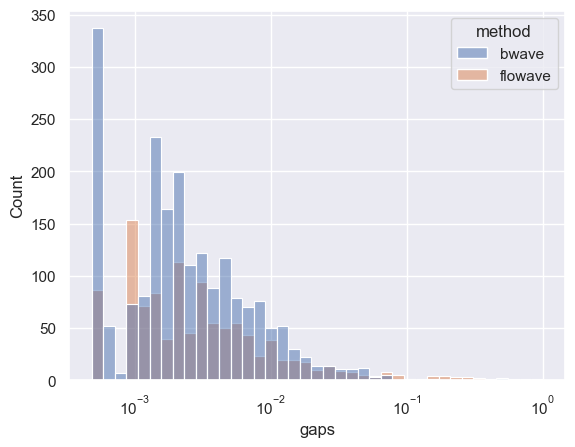

In [29]:
sns.histplot(data = gap_data, x = 'gaps', hue = 'method', log_scale=True)

Text(0.5, 0, 'size of gaps (# frames in a row that are not measured)')

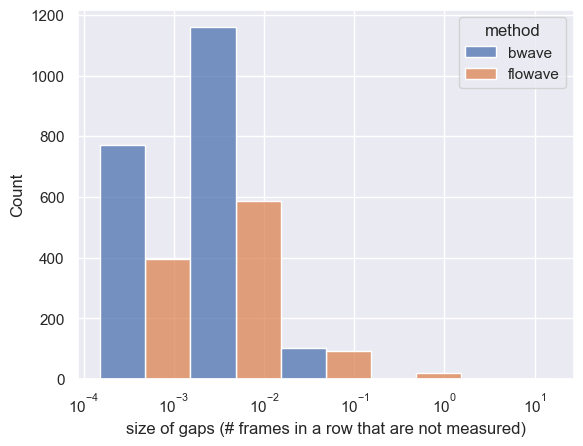

In [28]:

sns.histplot(data = gap_data, x = 'gaps', hue = 'method', log_scale=True, discrete = True, multiple='dodge')
plt.xlabel("size of gaps (# frames in a row that are not measured)")